<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [24]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy import units as u

redpath = "/home/c604c396/RFSLAB/USER_DPT/c604c396/ASTR596/Data/Reduced/20191106/"

A routine to display in image

In [25]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

<h3> Find the stars in your image</h3>

In [26]:
#filename should be the name of the combined image file (without path) that has the original header
#wcsfilename should be the name of the image that has the correct WCS header, e.g. one output
#by astrometry.net. 
def read_one_image(filename, wcsfilename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)
    wcsfile = os.path.join('{}'.format(redpath), wcsfilename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    wcshdr = fits.getheader(wcsfile)

    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(wcshdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [27]:
#img_ngc7296_V, hdr_ngc7296_V, imgwcs_ngc7296_V, imgfile_ngc7296_V = read_one_image('ngc7276_V_comb.fits','wngc7276_V_comb.fits',redpath)
#img_ngc7296_B, hdr_ngc7296_B, imgwcs_ngc7296_B, imgfile_ngc7296_B = read_one_image('ngc7276_B_comb.fits','wngc7276_B_comb.fits',redpath)

img_ngc7128_V, hdr_ngc7128_V, imgwcs_ngc7128_V, imgfile_ngc7128_V = read_one_image('ngc7128_V_comb.fits','wngc7128_V_comb.fits',redpath)
img_ngc7128_B, hdr_ngc7128_B, imgwcs_ngc7128_B, imgfile_ngc7128_B = read_one_image('ngc7128_B_comb.fits','wngc7128_B_comb.fits',redpath)
img_nova_R_JOHN, hdr_nova_R_JOHN, imgwcs_nova_R_JOHN, imgfile_nova_R_JOHN = read_one_image('nova_R_JOHN_comb.fits','wnova_R_JOHN_comb.fits',redpath)
img_nova_V, hdr_nova_V, imgwcs_nova_V, imgfile_nova_V = read_one_image('nova_V_comb.fits','wnova_V_comb.fits',redpath)
img_nova_B, hdr_nova_B, imgwcs_nova_B, imgfile_nova_B = read_one_image('nova_B_comb.fits','wnova_B_comb.fits',redpath)

Reading /home/c604c396/RFSLAB/USER_DPT/c604c396/ASTR596/Data/Reduced/20191106/ngc7128_V_comb.fits
Reading /home/c604c396/RFSLAB/USER_DPT/c604c396/ASTR596/Data/Reduced/20191106/ngc7128_B_comb.fits
Reading /home/c604c396/RFSLAB/USER_DPT/c604c396/ASTR596/Data/Reduced/20191106/nova_R_JOHN_comb.fits
Reading /home/c604c396/RFSLAB/USER_DPT/c604c396/ASTR596/Data/Reduced/20191106/nova_V_comb.fits
Reading /home/c604c396/RFSLAB/USER_DPT/c604c396/ASTR596/Data/Reduced/20191106/nova_B_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [28]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [29]:
#***********
#bkg_V = get_sky_background(img_ngc7296_V, verbose=True)
#img_ngc7296_V_nosky = img_ngc7296_V - bkg_V.background

#bkg_B = get_sky_background(img_ngc7296_B, verbose=True)
#img_ngc7296_B_nosky = img_ngc7296_B - bkg_B.background

bkg_ngc7128_V = get_sky_background(img_ngc7128_V, verbose=True)
img_ngc7128_V_nosky = img_ngc7128_V - bkg_ngc7128_V.background

bkg_ngc7128_B = get_sky_background(img_ngc7128_B, verbose=True)
img_ngc7128_B_nosky = img_ngc7128_B - bkg_ngc7128_B.background

Sky background median = 3.354, rms = 0.064 electrons.
Sky background median = 3.158, rms = 0.063 electrons.


In [30]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

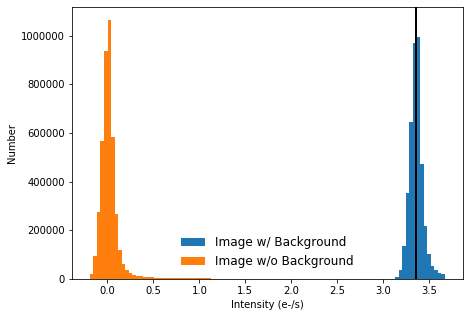

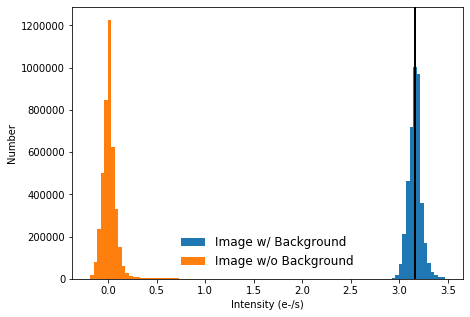

In [31]:
#***********
qa_background(img_ngc7128_V, img_ngc7128_V_nosky,bkg_ngc7128_V)
qa_background(img_ngc7128_B, img_ngc7128_B_nosky,bkg_ngc7128_B)

This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*
*viewer=imexam.connect()*
*viewer.load_fits('<filename>')*
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [32]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [33]:
#***********
#srcs_ngc7296_V = find_stars(img_ngc7296_V_nosky, imgfile_ngc7296_V, sigma=bkg_V.background_rms_median, nsigma=5, 
 #                 verbose=True, overwrite=False)
#srcs_ngc7296_V

srcs_ngc7128_V = find_stars(img_ngc7128_V_nosky, imgfile_ngc7128_V, sigma=bkg_ngc7128_V.background_rms_median, nsigma=5, 
                            fwhm=3.84, verbose=True, overwrite=False)
srcs_ngc7128_V

Read 1669 stars from /home/c604c396/RFSLAB/USER_DPT/c604c396/ASTR596/Data/Reduced/20191106/stars-ngc7128_V_comb.fits


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
640,1839.8252897492343,1002.1742784031806,0.3700133056370352,0.028850011710272582,-0.2876435878555822,25,0.0,1163.606035979143,2271.1565253797635,-8.390617665763088
208,866.9936271833726,348.6142566520104,0.37441300225457524,0.27482477746108164,-0.2469045606213392,25,0.0,1179.9809767365114,2259.0945899946446,-8.384836038846593
789,2015.348790218435,1160.6546595343366,0.3189616944483625,0.22024410296440597,0.19122082617237446,25,0.0,1171.1764724044879,2133.3069433161154,-8.32263336717258
1233,1167.210793284432,1524.8191432279077,0.327182215736448,0.04905099974724485,-0.29524814467651705,25,0.0,1171.5877349861523,2014.498313969263,-8.260417270606409
1102,1237.3639653739776,1421.3038331108648,0.4571793823981911,0.07294082785361772,-0.2492305495479606,25,0.0,1185.6713995975824,1868.0415726174726,-8.178466342686825
786,2015.2634735019221,1159.8200242488456,0.4288056360888422,0.12942527999096493,-0.2006606234128764,25,0.0,1114.6138151787502,1750.1784556226241,-8.107705833631172
1105,1262.4673979908187,1423.9895274578487,0.44565430612488516,0.004300857606000965,-0.2653876097336618,25,0.0,825.1575277557592,1708.5022555563637,-8.081538891221555
780,2015.2056774238906,1159.5826344551233,0.46912855520373353,-0.3550492853163409,-0.44275438854833216,25,0.0,1167.7787085052928,1623.9478312755923,-8.026430183948465
1104,1236.6576199861397,1421.5279933921067,0.5000484676994618,0.24016454575399465,-0.4907582143653345,25,0.0,1060.7354792337499,1620.2665168825997,-8.023966143287682


In [34]:
#srcs_ngc7296_B = find_stars(img_ngc7296_B_nosky, imgfile_ngc7296_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  #verbose=True, overwrite=False)
#srcs_ngc7296_B

srcs_ngc7128_B = find_stars(img_ngc7128_B_nosky, imgfile_ngc7128_B, sigma=bkg_ngc7128_B.background_rms_median, nsigma=5, 
                            fwhm=5.13, verbose=True, overwrite=False)
srcs_ngc7128_B

Read 663 stars from /home/c604c396/RFSLAB/USER_DPT/c604c396/ASTR596/Data/Reduced/20191106/stars-ngc7128_B_comb.fits


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
496,710.1480131835723,1493.863210004133,0.4463328831872179,0.006607554649570228,-0.34516600360088284,25,0.0,922.0677577958598,1385.0280067336942,-7.853646388459512
65,538.7943935947302,335.54298263606074,0.4208728640338003,-0.025810862295848468,-0.10817147684430745,25,0.0,731.7480364789205,1078.5125800521973,-7.582063037980711
503,838.3281554435137,1512.059551930846,0.431664912800844,-0.05231304988663836,-0.28940910581361323,25,0.0,589.9507269437048,902.9366933195906,-7.389143255335904
229,1511.4818170422936,989.6303681664607,0.44440532091691376,-0.20727371527823968,-0.41673682349357694,25,0.0,546.0057103265466,782.8225999883435,-7.234158387982754
294,1686.914664095385,1147.2787372768676,0.4069064820166571,-0.2264692689108435,-0.44287607120527317,25,0.0,509.0129001092817,659.1087029885964,-7.047392615449127
383,900.7222211346202,1304.7040981610971,0.44646336264915987,-0.25321586547025143,-0.4124844115685716,25,0.0,297.6431133978122,467.55913047555515,-6.674591355750473
448,933.7437796131993,1411.2673386112278,0.4198557815250876,-0.09463112834118807,-0.31822924106408157,25,0.0,296.9897312129078,466.43537900960115,-6.6719787103267825
440,730.4757696937534,1398.4911674403686,0.46562992488568605,-0.13155018724597536,-0.3760686709431961,25,0.0,285.05394511710807,432.0827765203857,-6.588917387536713
357,361.0193621960723,1267.0669322133676,0.4288545444000124,-0.054299182429854286,-0.29170273212376385,25,0.0,256.4483757941154,404.738516924126,-6.517936339936402


<h3> Use stars from Pan-STARRS</h3>

We will be using the large survey called Pan-STARRS (https://panstarrs.stsci.edu/).  Pan-STARRS uses SDSS filters (*griz*), which are different from the "Johnson" *BVR* filters that we are using.  But there are transformation between these filters such that if we know the Pan-STARRS magnitudes of a given object, we can determine its B-V color.

This routine sends a request to a catalog server at a remote location and pulls back all the photometry

In [35]:
def get_panstarrs_catalog(imgwcs, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    

    #we limit ourselves to bright objects so that we know that they will have high Signal-to-Noise
    rmag = allcat['rMeanPSFMag']
    good = np.isfinite(rmag) * rmag < rfaint
    cat = allcat[good]
    print('Keeping {}/{} Pan-STARRS sources with rmag< {}.'.format(len(cat), len(allcat),rfaint))
    
    #make B and V-band magnitudes using the transformations published in Tonry et al. (2012)
    #https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T/abstract
    cat['B'] = 0.213 + 0.587 * (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['gMeanPSFMag'] 
    cat['V'] = 0.006 + 0.474 *  (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['rMeanPSFMag'] 
    
    return cat

In [36]:
#%time refcat_ngc7296_V = get_panstarrs_catalog(imgwcs_ngc7296_V, radius=0.2)
#refcat_ngc7296_V

%time refcat_ngc7128_V = get_panstarrs_catalog(imgwcs_ngc7128_V, radius=0.2)
refcat_ngc7128_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=326.02067,53.75146


Keeping 889/918 Pan-STARRS sources with rmag< 17.
CPU times: user 54.5 ms, sys: 3.32 ms, total: 57.8 ms
Wall time: 3.32 s


objID,raMean,decMean,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,B,V
int64,float64,float64,float64,float64,float64,float64,float64,float64
172473260768521639,326.07689699,53.72576179,12.62600040435791,12.357000350952148,12.225000381469727,12.104000091552734,12.996903435707093,12.49050637626648
172353260800752122,326.08018881,53.6261404,12.89900016784668,12.418000221252441,12.175000190734863,12.008000373840332,13.394347136497498,12.65199419593811
172503258801023374,325.88018571,53.75214275,12.98900032043457,12.449000358581543,12.175000190734863,12.00100040435791,13.518980298042298,12.710960340499877
172493261417666169,326.14181906,53.74626654,12.76200008392334,12.50100040435791,12.41100025177002,12.37600040435791,13.128206895828248,12.630714252471924
172283259963169350,325.99613641,53.57397055,12.523200035095215,12.515899658203125,15.077400207519531,12.579099655151367,12.740485356330872,12.525360036849976
172553259686507433,325.96868718,53.79724702,12.994000434875488,12.564000129699707,12.359000205993652,12.22700023651123,13.459410614013672,12.773820274353028
172643260773104920,326.07735979,53.8701416,12.972000122070312,12.564000129699707,12.312000274658203,12.13700008392334,13.424496117591858,12.763392126083374
172473259798384953,325.97983039,53.7285263,12.942000389099121,12.62600040435791,12.479000091552734,12.37600040435791,13.340492380142212,12.781784397125245
172633258688450529,325.86897433,53.85810969,13.112000465393066,12.708000183105469,12.503000259399414,12.350000381469727,13.562148631095885,12.90549631690979


In [37]:
%time refcat_ngc7128_B = get_panstarrs_catalog(imgwcs_ngc7128_B, radius=0.2)
refcat_ngc7128_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=325.96526,53.75027
Keeping 876/901 Pan-STARRS sources with rmag< 17.
CPU times: user 26.1 ms, sys: 4.19 ms, total: 30.3 ms
Wall time: 3.1 s


objID,raMean,decMean,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,B,V
int64,float64,float64,float64,float64,float64,float64,float64,float64
172473260768521639,326.07689699,53.72576179,12.62600040435791,12.357000350952148,12.225000381469727,12.104000091552734,12.996903435707093,12.49050637626648
172353260800752122,326.08018881,53.6261404,12.89900016784668,12.418000221252441,12.175000190734863,12.008000373840332,13.394347136497498,12.65199419593811
172503258801023374,325.88018571,53.75214275,12.98900032043457,12.449000358581543,12.175000190734863,12.00100040435791,13.518980298042298,12.710960340499877
172493261417666169,326.14181906,53.74626654,12.76200008392334,12.50100040435791,12.41100025177002,12.37600040435791,13.128206895828248,12.630714252471924
172283259963169350,325.99613641,53.57397055,12.523200035095215,12.515899658203125,15.077400207519531,12.579099655151367,12.740485356330872,12.525360036849976
172553259686507433,325.96868718,53.79724702,12.994000434875488,12.564000129699707,12.359000205993652,12.22700023651123,13.459410614013672,12.773820274353028
172643260773104920,326.07735979,53.8701416,12.972000122070312,12.564000129699707,12.312000274658203,12.13700008392334,13.424496117591858,12.763392126083374
172473259798384953,325.97983039,53.7285263,12.942000389099121,12.62600040435791,12.479000091552734,12.37600040435791,13.340492380142212,12.781784397125245
172633258688450529,325.86897433,53.85810969,13.112000465393066,12.708000183105469,12.503000259399414,12.350000381469727,13.562148631095885,12.90549631690979


We need to match the Pan-STARRS catalog against ours.  First we need to compute the nearest Pan-STARRS star to each of ours and look at the distribution of distances to find the optimal match.

In [38]:
def sep_check(imgwcs,srcs,refcat):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    #this makes an instance of a SkyCoord class containing the RAs and Decs from Pan-STARRS objects
    refcoord = SkyCoord(ra=refcat['raMean']*u.deg, dec=refcat['decMean']*u.deg)
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars = imgwcs.all_pix2world(srcs['xcentroid']+1, srcs['ycentroid']+1, 1)
    #this does the same from our targets 
    coord = SkyCoord(ra=radec_stars[0]*u.deg, dec=radec_stars[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord.match_to_catalog_sky(refcoord)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    return refcoord, coord

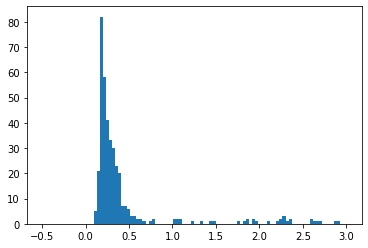

In [39]:
#refcoord_ngc7296_V, coord_ngc7296_V = sep_check(imgwcs_ngc7296_V,srcs_ngc7296_V,refcat_ngc7296_V)

refcoord_ngc7128_V, coord_ngc7128_V = sep_check(imgwcs_ngc7128_V,srcs_ngc7128_V,refcat_ngc7128_V)

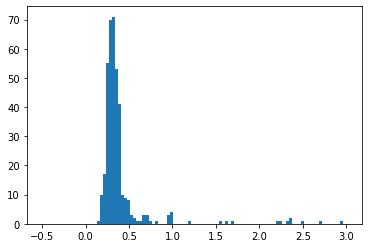

In [40]:
#refcoord_ngc7296_B, coord_ngc7296_B = sep_check(imgwcs_ngc7296_B,srcs_ngc7296_B,refcat_ngc7296_B)

refcoord_ngc7128_B, coord_ngc7128_B = sep_check(imgwcs_ngc7128_B,srcs_ngc7128_B,refcat_ngc7128_B)

It looks like the optimal match is less than 1.0 arcsec.  The following routine matches to within this tolerance

In [41]:
#take two lists of coordinates 
def match_src_ref(refcoord, coord, srcs, img, radasec = 1.0):
    rad = radasec * u.arcsec

    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_ref, indx, d2d, _ = coord.search_around_sky(refcoord, rad)
    nmatch = len(indx_ref)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs), rad))
    display_image(img, srcs=srcs[indx], calibrated=True)
    return indx, indx_ref

Found 347/1669 stars within 1.0 arcsec
Found 365/663 stars within 1.0 arcsec


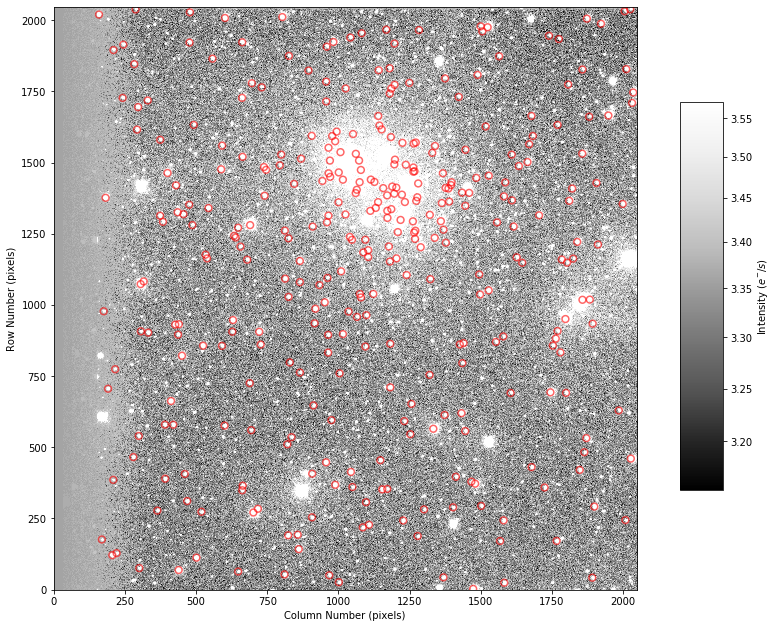

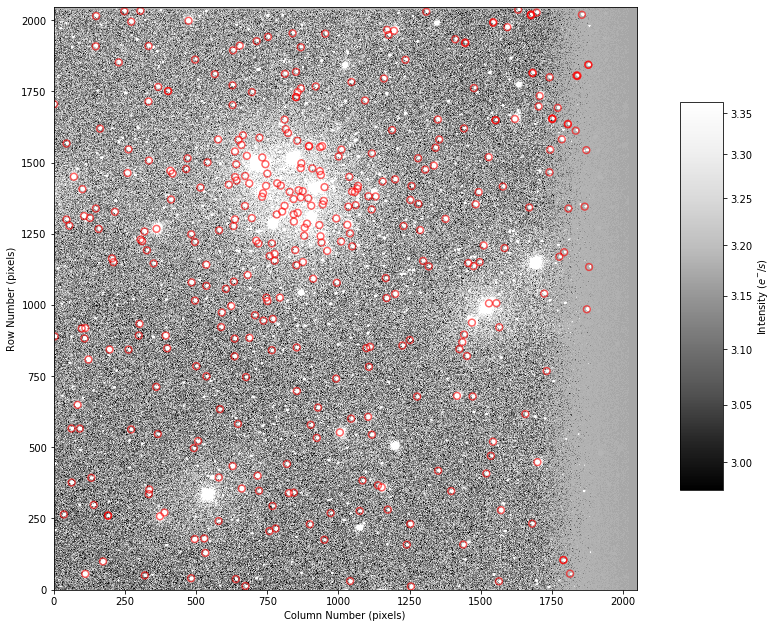

In [42]:
#indx_ngc7296_V, indx_ref_ngc7296_V = match_src_ref(refcoord_ngc7296_V, coord_ngc7296_V, srcs_ngc7296_V, img_ngc7296_V)
#indx_ngc7296_B, indx_ref_ngc7296_B = match_src_ref(refcoord_ngc7296_B, coord_ngc7296_B, srcs_ngc7296_B, img_ngc7296_B)

indx_ngc7128_V, indx_ref_ngc7128_V = match_src_ref(refcoord_ngc7128_V, coord_ngc7128_V, srcs_ngc7128_V, img_ngc7128_V)
indx_ngc7128_B, indx_ref_ngc7128_B = match_src_ref(refcoord_ngc7128_B, coord_ngc7128_B, srcs_ngc7128_B, img_ngc7128_B)

Now let's calculate the zeropoints for each image.  To compare our objects to those from Pan-STARRS we will need to correct for the effects of airmass.

We start by specifying the atmospheric extinction coefficient for each object.  This says for a typical atmosphere, how much the magnitude changes for an increase in airmass of 1.  We could have measured this using mutliple standard stars but will just assume a cannonical value for now.

In [43]:
def zp_meas(srcs, refcat, indx, indx_ref, hdr):
    kext = {'B': 0.4, 'V': 0.2}
    import numpy.ma as ma

    #this consists of the instrumental magnitude, which is the magnitude, including an airmass correction
    #but without a true zeropoint.  The second term says how the magnitude 
    #m(inst) = -2.5 * log(flux) - (sec z) * k
    instmag = srcs['mag'][indx].data - hdr['AIRMASS'] * kext[hdr['FILTER']]

    #the Pan-STARRS magnitudes for the same objects, as indicated using the indx_ref array
    psmag = refcat[hdr['FILTER']][indx_ref].data

    #calculate the median zeropoint defined as
    #psmag = -2.5 * log(flux) - (sec z) * k + ZP = m(inst) + ZP
    medzp = np.median(psmag - instmag)
    print(hdr['FILTER'],'zeropoint = ', medzp)
    print('Airmass in {} was {}'.format(hdr['FILTER'], hdr['AIRMASS']))
    return medzp

In [44]:
#ZPV = zp_meas(srcs_ngc7296_V,refcat_ngc7296_V, indx_ngc7296_V, indx_ref_ngc7296_V,hdr_ngc7296_V)
#ZPB = zp_meas(srcs_ngc7296_B,refcat_ngc7296_B, indx_ngc7296_B, indx_ref_ngc7296_B,hdr_ngc7296_B)

ZPV = zp_meas(srcs_ngc7128_V,refcat_ngc7128_V, indx_ngc7128_V, indx_ref_ngc7128_V,hdr_ngc7128_V)
ZPB = zp_meas(srcs_ngc7128_B,refcat_ngc7128_B, indx_ngc7128_B, indx_ref_ngc7128_B,hdr_ngc7128_B)

/home/c604c396/.conda/envs/python3env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


V zeropoint =  20.492961807535114
Airmass in V was 1.217104
B zeropoint =  20.18092631278609
Airmass in B was 1.163366


Now match the B and V-band catalogs together for this cluster, apply the zeropoints, and plot a CMD!

In [45]:
def make_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, ZPB, ZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + ZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + ZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    #print(magB-magV)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(magB-magV, magV, 'ro',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show


Found 623/663 stars within 1.0 arcsec


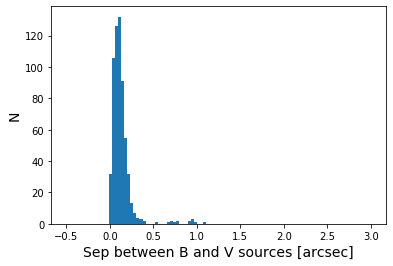

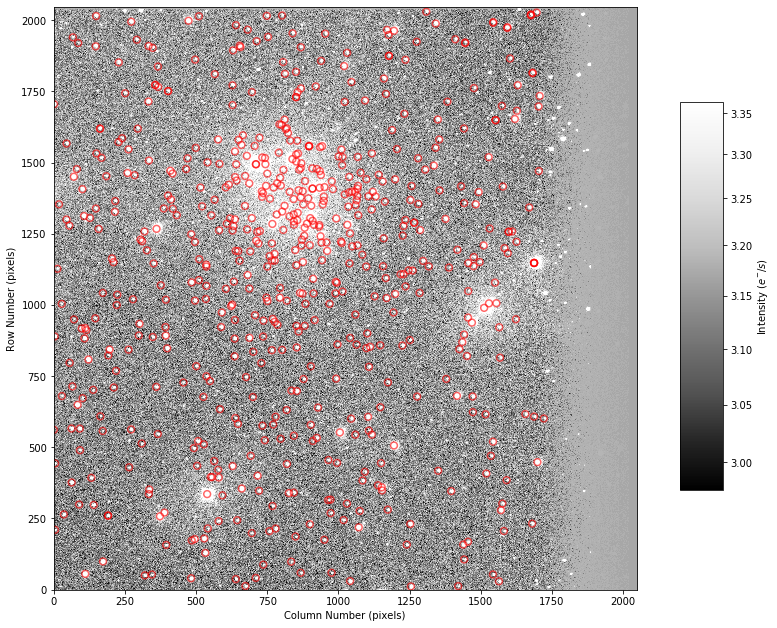

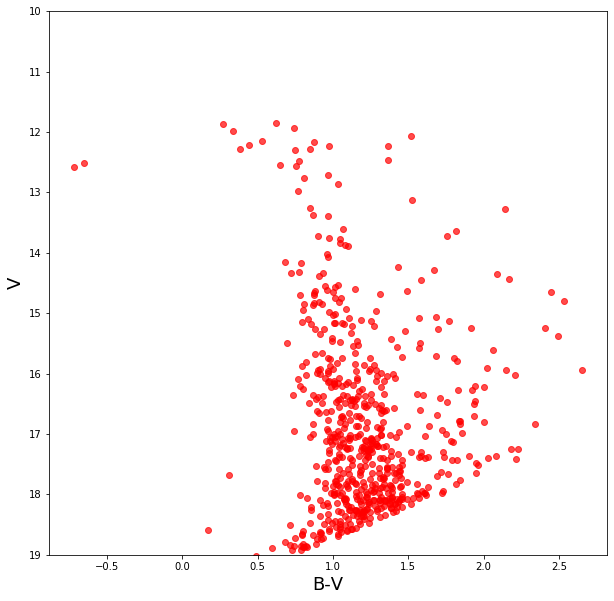

In [46]:
#make_CMD(img_ngc7296_B, imgwcs_ngc7296_B, srcs_ngc7296_B,imgwcs_ngc7296_V, srcs_ngc7296_V, hdr_ngc7296_B, hdr_ngc7296_V, ZPB, ZPV, radasec = 1.0)

make_CMD(img_ngc7128_B, imgwcs_ngc7128_B, srcs_ngc7128_B, imgwcs_ngc7128_V, srcs_ngc7128_V, hdr_ngc7128_B, hdr_ngc7128_V, ZPB, ZPV, radasec = 1.0)

One way to check that the color-magnitude diagram is correct is by checking it with WEBDA. The WEBDA color-magnitude diagram for NGC 7128 has less noise, but does look similar.